In [1]:
import rasa_core
from rasa_core.agent import Agent
from bokeh.io import output_notebook
agent = Agent.load("models/dialogue_embed")
# agent = Agent.load("models/dialogue_embed_before_norm_loss")
output_notebook()

/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


INFO:tensorflow:Restoring parameters from models/dialogue_embed/policy_0_EmbeddingPolicy/tensorflow_embedding.ckpt


/anaconda/lib/python3.6/site-packages/pykwalify/core.py:99: UnsafeLoaderWarning: 
The default 'Loader' for 'load(stream)' without further arguments can be unsafe.
Use 'load(stream, Loader=ruamel.yaml.Loader)' explicitly if that is OK.
Alternatively include the following in your code:

  import warnings
  warnings.simplefilter('ignore', ruamel.yaml.error.UnsafeLoaderWarning)

In most other cases you should consider using 'safe_load(stream)'
  data = yaml.load(stream)


Loading BokehJS ...

In [2]:
policy = agent.policy_ensemble.policies[0]
interpreter = agent.interpreter

In [3]:
domain = agent.domain


In [4]:
from rasa_core.training.structures import StoryGraph
from rasa_core.training.dsl import StoryFileReader
from rasa_core.trackers import DialogueStateTracker
from rasa_core.channels import UserMessage
import numpy as np
np.set_printoptions(precision=3, suppress=True)

def embedding_from_tracker(story, bot=False):
    reader = StoryFileReader(domain, interpreter)
    story = story.split('\n')
    story_steps = reader.process_lines(story)
#     story_graph = StoryGraph(story_steps)
    tracker = DialogueStateTracker(
            1,
            domain.slots
    )
    tracker._reset()
    for step in story_steps:
        events = step.explicit_events(domain)
        for event in events:
            tracker.update(event)
    data_X = policy.featurizer.create_X([tracker], domain)
    session_data = policy._create_tf_session_data(domain, data_X)
    all_Y_d_x = np.stack([session_data.all_Y_d for _ in range(session_data.X.shape[0])])
    feed_dict={policy.a_in: session_data.X,
               policy.b_in: all_Y_d_x,
               policy.c_in: session_data.slots,
               policy.b_prev_in: session_data.previous_actions,
               policy._dialogue_len: session_data.X.shape[1],
               policy._x_for_no_intent_in: session_data.x_for_no_intent,
               policy._y_for_no_action_in: session_data.y_for_no_action,
               policy._y_for_action_listen_in: session_data.y_for_action_listen}

    dial_vec = policy.session.run(policy.dial_embed, feed_dict=feed_dict)
    bot_vec = policy.session.run(policy.bot_embed, feed_dict=feed_dict)

    no_skip_gate = policy.session.run(policy.copy_attn_debug, feed_dict=feed_dict)
    attn_embed = policy.session.run(policy.attn_embed, feed_dict=feed_dict)
    rnn_embed = policy.session.run(policy.rnn_embed, feed_dict=feed_dict)
    probs = policy.session.run(policy.alignment_history, feed_dict=feed_dict)
    sim = policy.session.run(policy.sim_op, feed_dict=feed_dict)

    del tracker
#     print(np.shape(dial_vec))

    if bot is False:
        return (dial_vec[0,-2,:],
                no_skip_gate[0,-2,:],
                attn_embed[0,-2,:],
                rnn_embed[0,-2,:],
                probs[0,-2,:],
                sim[0,-2,:])
    else:
        return bot_vec
    
def make_prediction(story):
    dial, _,_,_,_, sim0 = embedding_from_tracker(story, bot=False)
    bot = embedding_from_tracker(story, bot=True)[0,-2,:,:]
    abs_vals = np.array([np.absolute(vec) for vec in bot])
    norms = np.apply_along_axis(np.linalg.norm, 1, bot)
    sims = np.dot(bot, dial)/norms
#     name = domain.action_for_index(np.argmax(sims)).name()
#     print(name)
    name = domain.action_for_index(np.argmax(sim0)).name()
#     print(name)
#     print('---')
#     ids = sim0.argsort()[::-1]
#     print(ids)
#     print(sims[ids])
    return '- ' + name, np.max(sim0)
#     print(dial.shape, bot.shape)

In [5]:
# print(domain.intents)
story_block = """* request_hotel
    - utter_ask_details
* explain
    - utter_explain_details_hotel
    - utter_ask_details
* chitchat
    - utter_chitchat
    - utter_ask_details
* inform{"enddate": "May 26th"}
    - slot{"enddate": "May 26th"}
    - utter_ask_startdate
* inform{"startdate": "next week"}
    - slot{"startdate": "next week"}
    - utter_ask_location
* correct{"startdate": "next week"}
    - slot{"startdate": "next week"}
    - utter_correct_startdate_hotel
    - utter_ask_location
* explain
    - utter_explain_location_hotel
    - utter_ask_location
* inform{"location": "rome"}
    - slot{"location": "rome"}
    - utter_ask_price
* chitchat
    - utter_chitchat
    - utter_ask_price
* chitchat
    - utter_chitchat
    - utter_ask_price
* chitchat
    - utter_chitchat
    - utter_ask_price
* chitchat
    - utter_chitchat
    - utter_ask_price
* explain
    - utter_explain_price_hotel
    - utter_ask_price
* inform{"price": "expensive"}
    - utter_ask_people
* inform{"people": "4"}
    - utter_filled_slots
    - action_search_hotel
    - slot{"hotel": "hotel"}
    - utter_suggest_hotel
* chitchat
    - utter_chitchat
    - utter_suggest_hotel
* affirm
    - utter_happy"""

In [6]:
# story_block = """* request_hotel
#     - utter_ask_details
# * inform{"people": "2"}
#     - slot{"people": "2"}
#     - utter_ask_location
# * did_that_work
#     - utter_more_info_hotel
#     - utter_ask_location
# * chitchat
#     - utter_chitchat
#     - utter_ask_location
# * did_that_work
#     - utter_more_info_hotel
#     - utter_ask_location
# * inform{"location": "paris"}
#     - utter_ask_price
# * inform{"price": "expensive"}
#     - utter_ask_startdate
# * inform{"startdate": "10.03.2018"}
#     - utter_ask_enddate
# * explain
#     - utter_explain_enddate_hotel
#     - utter_ask_enddate
# * chitchat
#     - utter_chitchat
#     - utter_ask_enddate
# * explain
#     - utter_explain_enddate_hotel
#     - utter_ask_enddate
# * inform{"enddate": "10.03.2018"}
#     - utter_filled_slots
#     - action_search_hotel
#     - slot{"hotel": "hotel"}
#     - utter_suggest_hotel
# * affirm
#     - utter_happy
# """

In [7]:
print(len(story_block.split('\n')))
cool_list = []
lines = story_block.split('\n')
for idx, line in enumerate(lines):
    if idx == len(lines)-1:
        continue
    if '*' in lines[idx+1] or 'slot{' in lines[idx+1]:
#     if 'slot{' in lines[idx+1]:
        continue
    sub_story = '\n'.join(lines[:idx+1])
    (dial, not_skip, attn, rnn, probs, sims
    ) = embedding_from_tracker("#generate story\n{}".format(sub_story))
    pred, sim = make_prediction("#generate story\n{}".format(sub_story))
    cool_list.append((lines[idx+1].strip(), dial, (pred, sim, sims), not_skip, attn[-20:], rnn,
                      probs[:20], probs[-20:]))

print(len(cool_list))
print(cool_list[0][4].shape)
#     break
# dial = embedding_from_tracker("#generate story\n{}".format(story_block)
# )
# print(dial.shape)
# print(len(story_block.split('\n')))

51
29
(20,)


In [31]:
import copy

# cool_list0 = copy.deepcopy(cool_list)
cool_list[27]

('- utter_suggest_hotel',
 array([ 0.089, -0.049,  0.038,  0.009, -0.175,  0.174, -0.05 ,  0.032,
        -0.202, -0.052, -0.042,  0.166,  0.166,  0.047, -0.159, -0.225,
         0.027,  0.13 , -0.164,  0.183], dtype=float32),
 ('- utter_suggest_hotel',
  0.95272386,
  array([-0.046, -0.251, -0.186, -0.177,  0.148, -0.016, -0.051,  0.094,
          0.039, -0.081, -0.067, -0.017,  0.953,  0.103, -0.084, -0.244,
         -0.059, -0.081, -0.242, -0.019, -0.2  , -0.093, -0.249, -0.038,
         -0.241,  0.047, -0.285, -0.015, -0.026, -0.136, -0.159, -0.303,
         -0.291, -0.171, -0.31 , -0.078, -0.256, -0.103, -0.13 , -0.1  ,
         -0.349, -0.392, -0.175, -0.231], dtype=float32)),
 array([0.962, 0.953, 0.   , 1.   , 0.   ], dtype=float32),
 array([ 0.002,  0.01 ,  0.009, -0.01 , -0.046,  0.039, -0.026,  0.014,
        -0.041, -0.002, -0.023,  0.032,  0.039,  0.018, -0.059, -0.077,
         0.02 ,  0.031, -0.09 ,  0.029], dtype=float32),
 array([ 0.087, -0.058,  0.029,  0.019, -0.129,

In [9]:
# cool_list1= copy.deepcopy(cool_list)
cool_list[19]

('- utter_ask_price',
 array([ 0.008,  0.075, -0.154, -0.103, -0.026,  0.039,  0.018,  0.104,
        -0.022,  0.04 ,  0.004, -0.051, -0.097, -0.082, -0.062, -0.06 ,
         0.039, -0.072, -0.009, -0.2  ], dtype=float32),
 ('- utter_ask_price',
  0.90243894,
  array([-0.124, -0.054, -0.098, -0.009,  0.263,  0.127,  0.902, -0.136,
          0.077, -0.014, -0.113, -0.12 , -0.205, -0.016, -0.486, -0.358,
         -0.46 , -0.441, -0.327, -0.389, -0.294, -0.153, -0.139, -0.542,
         -0.328,  0.075, -0.031,  0.062,  0.005,  0.148, -0.525, -0.347,
         -0.342, -0.161, -0.137, -0.456, -0.31 , -0.651, -0.547,  0.021,
         -0.055, -0.044,  0.047, -0.351], dtype=float32)),
 array([0.997, 0.902, 0.   , 1.   , 0.   ], dtype=float32),
 array([-0.013,  0.031, -0.122, -0.108, -0.038,  0.05 ,  0.051,  0.055,
         0.023,  0.037, -0.003,  0.017, -0.081, -0.045, -0.087, -0.046,
         0.027, -0.05 , -0.074, -0.149], dtype=float32),
 array([ 0.022,  0.044, -0.032,  0.005,  0.012, -0.011,

In [10]:
import matplotlib.pyplot as plt
plt.plot(cool_list[15][-2], marker='x')

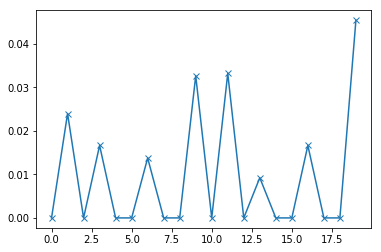

In [11]:
plt.plot(cool_list[19][-2], marker='x')

In [12]:
from sklearn.decomposition import PCA

In [13]:
pca = PCA(n_components=2)
X = pca.fit_transform([ting[1] for ting in cool_list])

In [14]:
from bokeh.plotting import figure, show
import matplotlib.pyplot as plt

In [15]:
embed_dim = cool_list[0][1].shape[0]


In [16]:
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool, Arrow, OpenHead

hover = HoverTool(tooltips=[("true action","@desc"), ("prediction", "@pred"),
                            ("not_skip_gate", "@not_skip")],names=['circle'])
p = figure( tools=[hover])

for i in range(1, len(X)):
    p.add_layout(Arrow(end=OpenHead(line_color="firebrick", size=10, line_width=2),
                       x_start=X[i-1,0], y_start=X[i-1,1],
                       x_end=X[i,0], y_end=X[i,1], line_color='gray'))

source = ColumnDataSource(data=dict(
    x=X[:,0],
    y=X[:,1],
    desc=[ting[0] for ting in cool_list],
    pred = [ting[2][0] for ting in cool_list],
    not_skip = [ting[3][-1] for ting in cool_list]
))
p.circle('x','y', source=source, size=10, name='circle')
# p.line(X[:,0], X[:,1])

X1 = pca.transform([ting[4] for ting in cool_list])
source = ColumnDataSource(data=dict(
    x=X1[:,0],
    y=X1[:,1],
    desc=[ting[0] for ting in cool_list],
    pred = [ting[2][0] for ting in cool_list],
    not_skip = [ting[3][-1] for ting in cool_list]
))
p.circle('x','y', source=source, size=5, color='green', name='circle')

X2 = pca.transform([ting[5] for ting in cool_list])
source = ColumnDataSource(data=dict(
    x=X2[:,0],
    y=X2[:,1],
    desc=[ting[0] for ting in cool_list],
    pred = [ting[2][0] for ting in cool_list],
    not_skip = [ting[3][-1] for ting in cool_list]
))
p.circle('x','y', source=source, size=5, color='red', name='circle')

x = pca.transform(np.zeros((1,embed_dim)))
p.circle(x[0,0], x[0,1], size=5, color='magenta')
p.circle(X[0,0], X[0,1], size=10, color='green')
p.circle(X[-1,0], X[-1,1], size=10, color='red')


GlyphRenderer(id='c5d66b4d-f272-4008-8554-229f36d1d5ce', ...)

In [17]:
show(p)

In [18]:
print('utter_ask_price', '-->', domain.index_for_action('utter_ask_price'))
print('utter_ask_details', '-->', domain.index_for_action('utter_ask_details'))
print('utter_ask_people', '-->', domain.index_for_action('utter_ask_people'))
print('utter_explain_details_hotel', '-->', domain.index_for_action('utter_explain_details_hotel'))
print('utter_explain_people_hotel', '-->', domain.index_for_action('utter_explain_people_hotel'))
print('utter_explain_price_hotel', '-->', domain.index_for_action('utter_explain_price_hotel'))
print('utter_ask_location', '-->', domain.index_for_action('utter_ask_location'))
print('utter_explain_location_hotel', '-->', domain.index_for_action('utter_explain_location_hotel'))
print('utter_ask_startdate', '-->', domain.index_for_action('utter_ask_startdate'))
print('utter_suggest_hotel', '-->', domain.index_for_action('utter_suggest_hotel'))
print('action_search_hotel', '-->', domain.index_for_action('action_search_hotel'))
print('action_listen', '-->', domain.index_for_action('action_listen'))

utter_ask_price --> 6
utter_ask_details --> 28
utter_ask_people --> 4
utter_explain_details_hotel --> 14
utter_explain_people_hotel --> 19
utter_explain_price_hotel --> 21
utter_ask_location --> 5
utter_explain_location_hotel --> 17
utter_ask_startdate --> 7
utter_suggest_hotel --> 12
action_search_hotel --> 42
action_listen --> 0


In [19]:
utter_price = embedding_from_tracker("#generate story\n{}".format(story_block), bot=True)[0,-1,5,:]
utter_price.shape

(20,)

In [20]:
print(utter_price.shape)
x = pca.transform(utter_price.reshape(1,-1))
p.circle(x[0][0], x[0][1], color='black')

(20,)


GlyphRenderer(id='1db745d9-cfee-44a7-8a51-a238a358f252', ...)

In [21]:
show(p)

In [22]:
from collections import namedtuple

In [23]:
Point = namedtuple('Point', ['x', 'y'])
p = Point(11, y=22)
p._asdict()

OrderedDict([('x', 11), ('y', 22)])

In [24]:
Point3D = namedtuple('Point3D', Point._fields + ('z',))

In [25]:
p_asdict = p._asdict()
p_asdict['z'] = 3
p_asdict

OrderedDict([('x', 11), ('y', 22), ('z', 3)])

In [26]:
p3D = Point3D(**p_asdict)
p3D

Point3D(x=11, y=22, z=3)

In [27]:
x ={
        "day": "20",
        "month": "06",
        "year": "2018"
    }

In [28]:
x

{'day': '20', 'month': '06', 'year': '2018'}

In [29]:
def value_touched_dict(value):
    if isinstance(value, dict) and value.get("day"):
        value["value1"] = value.pop("day")
        value["value2"] = value.pop("month")
        value["value3"] = value.pop("year")
    return {"value": value,
            "touched": True}
value_touched_dict(x)

{'touched': True, 'value': {'value1': '20', 'value2': '06', 'value3': '2018'}}

In [30]:
value_touched_dict('x')

{'touched': True, 'value': 'x'}